<a id = "2"></a><br>
## Load Python Packages and Access Data

In [ ]:
#basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tools for accessing and reading data (you do not need to use all of them)
import os
import pathlib
import PIL
import cv2
import skimage
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm
import lime

# Tensorflow basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image


#Lime package for ML explainability
from lime import lime_image

# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=fa76c839ecbaabef56063864dfb605fb1cc00459bfba39186ca1b225995c5722
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_url = "/content/drive/MyDrive/dataset/tobeaugmented/"
data_dir = pathlib.Path(dataset_url)
data_dir

PosixPath('/content/drive/MyDrive/dataset/tobeaugmented')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

386


In [ ]:
#non defect sample
non_defect = list(data_dir.glob('non-defect/*'))
PIL.Image.open(non_defect[0])

Let's also see one of the non-defective parts.

In [ ]:
#defected sample

defected = list(data_dir.glob('defected/*'))
PIL.Image.open(defected[1])


Okay, we have an idea about good and bad works now.

In [ ]:
sample1= imread(defected[1])
sample1.shape

(1860, 4032, 3)

<a id = "3"></a><br>
## Prepare Data For Model Consumption

Okay, we accessed to data and checked some samples. Now we can transform the data so that our CNN models can consume them. But before that, I want to define a few useful parameters so we can tweak them in a single place instead of searching them in the different code blocks.

In [ ]:
batch_size = 64
epochs=200
img_height = 299
img_width = 299
img_size = (img_height, img_width)

In [ ]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    labels='inferred',
    class_names = ['defected', 'non-defect'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 386 files belonging to 2 classes.
Using 309 files for training.


In [ ]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    labels='inferred',
    class_names = ['defected', 'non-defect'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 386 files belonging to 2 classes.
Using 77 files for validation.


Let's check target variables...

In [ ]:
class_names = train_set.class_names
print(class_names)

['defected', 'non-defect']


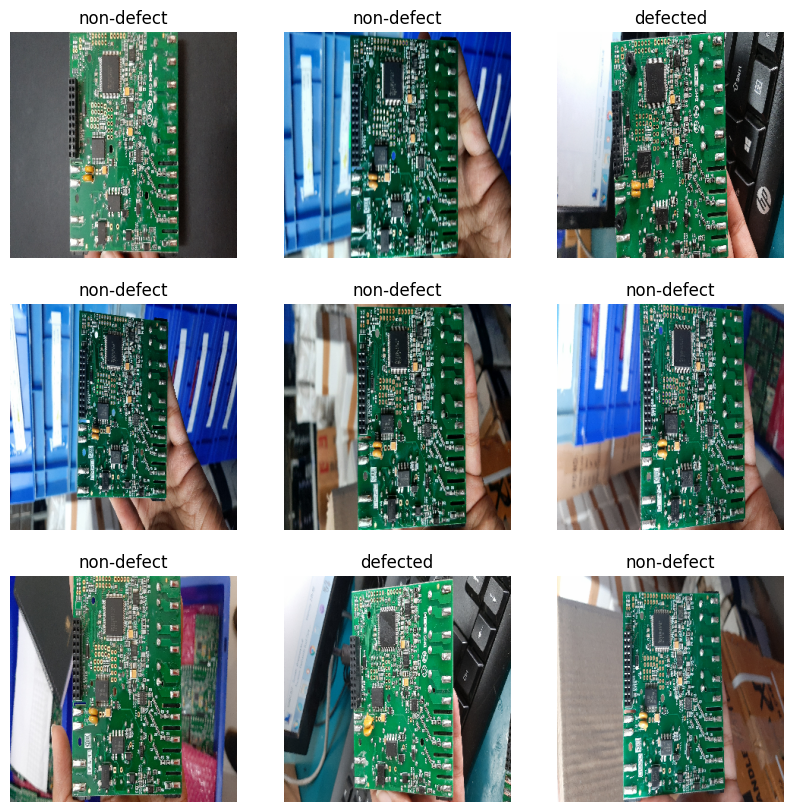

In [ ]:
# Let's see some more samples
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 299, 299, 3)
(64,)


<a id = "4"></a><br>
## Efficient Input Pipelines

I used GPU accelator on this notebook since we have a relatively small data set. However, whether you use GPU or TPU achieving peak performance on training speed requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build efficient input pipelines. The following few lines of codes are sufficient for a significant speed increase.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

<a id = "5"></a><br>
## Data Augmentation

I decided to use the following ones:

* Random flip: All sample images may not be taken same oriantation, so we can flip the images both on the horizontal and vertical axis
* Random zoom: Some of the images are zoomed. We can also add random zoomed versions of all samples to the training set
* Random contrast: Some images are darker than others. Let's add some random contrast.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)


<a id = "6"></a><br>
## Building a Custom Model

Okay, we take care of everything regarding our data. Let's create our model.


In [ ]:
custom_model = Sequential([

  layers.Rescaling(1./255),
  data_augmentation,

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
custom_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

<a id = "7"></a><br>
## Callbacks

Before training, we can construct some callbacks. I used two callbacks here:

* A custom callback to stop the learning process when a desired accuracy is reached
* A callback to control the learning rate during training.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)



<a id = "8"></a><br>
## Custom Model Performance

Let's train our model.

In [ ]:
history1 = custom_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=10, #200
                            callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/10
5/5 [==============================] - 111s 23s/step - loss: 0.4930 - accuracy: 0.7638 - val_loss: 0.6770 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 93s 19s/step - loss: 0.4600 - accuracy: 0.8026 - val_loss: 0.4543 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 97s 20s/step - loss: 0.3168 - accuracy: 0.8964 - val_loss: 0.1036 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 113s 23s/step - loss: 0.1590 - accuracy: 0.9288 - val_loss: 0.0907 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 104s 21s/step - loss: 0.0985 - accuracy: 0.9644 - val_loss: 0.0078 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
5/5 [==============================] - 96s 20s/step - loss: 0.0707 - accuracy: 0.9644 - val_loss: 0.0238 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
5/5 [==============================] - 101s 21s/step - loss: 0.1829 - accu

In [ ]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                 

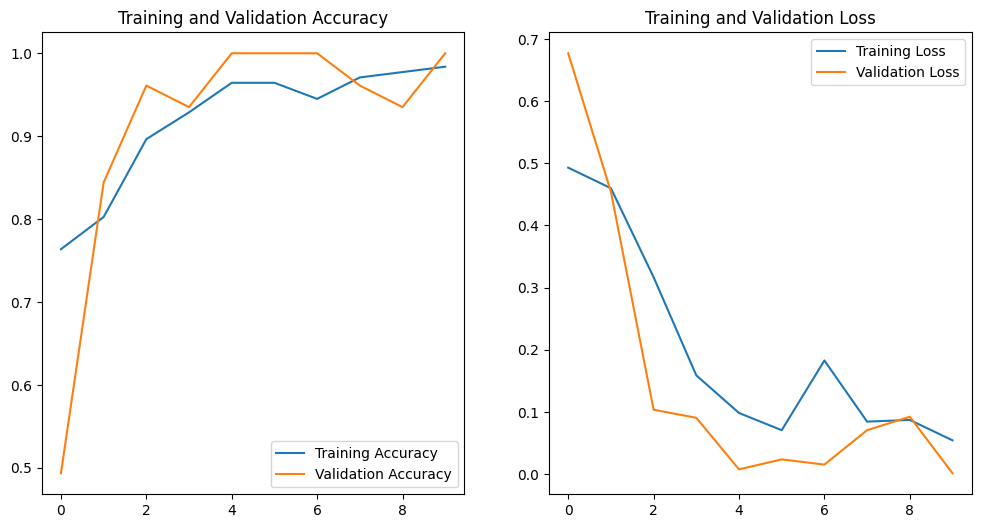

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We get a 100% accuracy both on training and validation sets.

<a id = "9"></a><br>
## Transfer Learning with Xception

Early layers of CNN models behave like feature extractors. Since pre-trained models are trained on large data sets, they already have rich feature representations of different objects. Those features could also help us when we have a small amount of data.

Xception is one of that pre-trained models and I will use it here.



In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


I decided to use the functional API instead of the sequential one here. This choice has no special point; you can also construct the model using sequential API. I just wanted to mention it and show its syntax.

In [ ]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [ ]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, #200
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 4.5138e-04 - accuracy: 1.0000 
Reached 100% accuracy so cancelling training!
5/5 [==============================] - 186s 36s/step - loss: 4.5138e-04 - accuracy: 1.0000 - val_loss: 5.3314e-06 - val_accuracy: 1.0000 - lr: 5.0000e-04


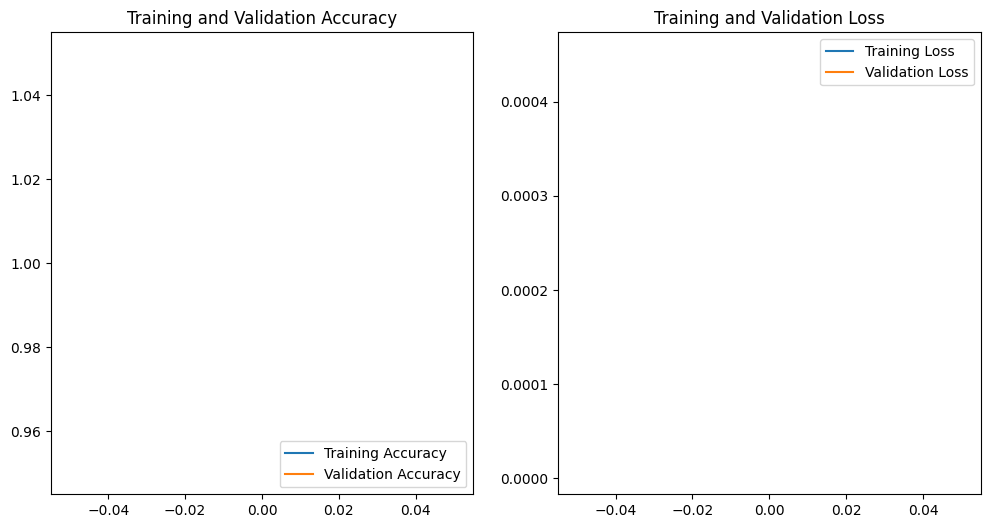

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               26214528  
                                                                 
 dense_3 (Dense)             (None, 1)                 129   

We again get a 100% accuracy both on training and validation sets with less epochs.

<a id = "10"></a><br>
## Model Explainability

Model explainability is vital to convince people that our model is working fine and its attention is at the correct place. I will use LIME package here.


In [ ]:
# The path to our target image
img_path = '/content/drive/MyDrive/dataset/tobeaugmented/defected/20200707_160659.jpg' #'/content/drive/MyDrive/Colab Notebooks/1200px-SEG_DVD_430_-_Printed_circuit_board-4276.jpg'
display(Image(img_path))


In [ ]:
def read_and_transform_img(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (img_height,img_width))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

In [ ]:
images = read_and_transform_img(img_path)

preds = pretrained_model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 [==============================] - 1s 558ms/step


In [ ]:
if prediction == 0:
    print("defected")
else:
    print("non_defected")

print(pct)

defected
1.0


<a id = "12"></a><br>
## LIME

In [ ]:
explainer = lime_image.LimeImageExplainer()


In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), custom_model.predict,
                                        top_labels=2, hide_color=0, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 1s 674ms/step


(-0.5, 298.5, 298.5, -0.5)

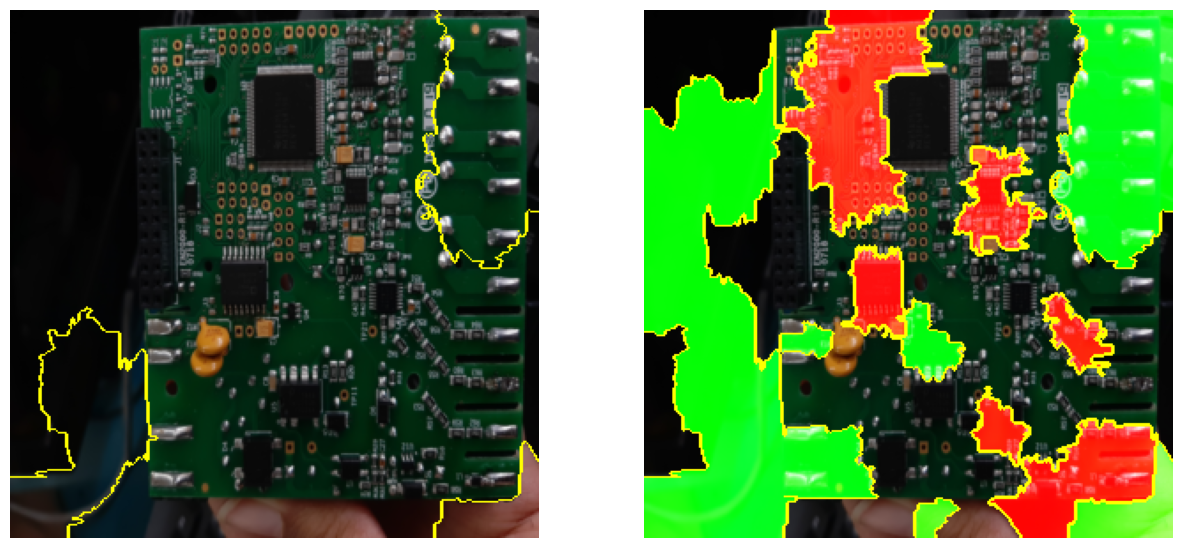

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Okay here story of this notebook ends. I hope you would enjoy it.